In [1]:
import os
import copy
import time
import random
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.io
import matplotlib.pyplot as plt
import glob
import re
from datetime import datetime
from dateutil import parser
import dateutil.parser
from scipy.io import savemat

import numpy as np
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading MR images
import math
import matplotlib.pyplot as plt
from scipy.stats import pearsonr,ttest_ind,spearmanr
from adjustText import adjust_text
from tabulate import tabulate
import plotly.graph_objects as go
import plotly.express as px


In [2]:
DATASET = 'DatasetPro4.0.csv'

In [3]:
data = pd.read_csv(DATASET)

### Student T-test

In [6]:
df_cn_mci = pd.DataFrame()

# Assign values to columns in the DataFrame
df_cn_mci['Feature'] = data.columns[858:1639]
df_cn_mci['log2FC'] = None
df_cn_mci['p-value'] = None
df_cn_mci['student T-test'] = None


# Loop through each feature column and calculate correlations
for feature in df_cn_mci['Feature']:
    # cn_data = data.loc[data['Group'].isin(['CN', 'MCI']), feature]
    cn_data = data[data['Group'] == 'CN'][feature]
    mci_data = data[data['Group'] == 'MCI'][feature]
    if len(cn_data) > len(mci_data):
        cn_data = cn_data[:len(mci_data)]
    else:
        mci_data = mci_data[:len(cn_data)]

    fold_change_CN_MCI = (np.log2(np.mean(cn_data))) - (np.log2(np.mean(mci_data)))
    
    t_statistic_lipid_CN_MCI, p_value_lipid_CN_MCI = ttest_ind(cn_data, mci_data)

    # Update the DataFrame with the correlation and p-value
    df_cn_mci.loc[df_cn_mci['Feature'] == feature, 'log2FC'] = fold_change_CN_MCI
    df_cn_mci.loc[df_cn_mci['Feature'] == feature, 'p-value'] = p_value_lipid_CN_MCI
    df_cn_mci.loc[df_cn_mci['Feature'] == feature, 'student T-test'] = t_statistic_lipid_CN_MCI
print(tabulate(df_cn_mci, headers = 'keys', tablefmt = 'psql'))

#---------------------------------------------------------------------------------------------------------------
df_cn_ad = pd.DataFrame()

# Assign values to columns in the DataFrame
df_cn_ad['Feature'] = data.columns[832:1613]
df_cn_ad['log2FC'] = None
df_cn_ad['p-value'] = None
df_cn_ad['student T-test'] = None

for feature in df_cn_ad['Feature']:
    cn_data = data[data['Group'] == 'CN'][feature]
    ad_data = data[data['Group'] == 'AD'][feature]

    if len(cn_data) > len(ad_data):
        cn_data = cn_data[:len(ad_data)]
    else:
        ad_data = ad_data[:len(cn_data)]

    fold_change_CN_AD = (np.log2(np.mean(cn_data))) - (np.log2(np.mean(ad_data)))

    t_statistic_lipid_CN_AD, p_value_lipid_CN_AD = ttest_ind(ad_data, cn_data)

    
    df_cn_ad.loc[df_cn_ad['Feature'] == feature, 'log2FC'] = fold_change_CN_AD
    df_cn_ad.loc[df_cn_ad['Feature'] == feature, 'p-value'] = p_value_lipid_CN_AD
    df_cn_ad.loc[df_cn_ad['Feature'] == feature, 'student T-test'] = t_statistic_lipid_CN_AD

#-------------------------------------------------------------------------------------------------------------------
df_mci_ad = pd.DataFrame()

# Assign values to columns in the DataFrame
df_mci_ad['Feature'] = data.columns[832:1613]
df_mci_ad['log2FC'] = None
df_mci_ad['p-value'] = None
df_mci_ad['student T-test'] = None


for feature in df_mci_ad['Feature']:
    mci_data = data[data['Group'] == 'MCI'][feature]
    ad_data = data[data['Group'] == 'AD'][feature]

    if len(mci_data) > len(ad_data):
        mci_data = mci_data[:len(ad_data)]
    else:
        ad_data = ad_data[:len(mci_data)]

    fold_change_MCI_AD = (np.log2(np.mean(mci_data))) - (np.log2(np.mean(ad_data)))

    t_statistic_lipid_MCI_AD, p_value_lipid_MCI_AD = ttest_ind(mci_data, ad_data)

    df_mci_ad.loc[df_mci_ad['Feature'] == feature, 'log2FC'] = fold_change_MCI_AD
    df_mci_ad.loc[df_mci_ad['Feature'] == feature, 'p-value'] = p_value_lipid_MCI_AD
    df_mci_ad.loc[df_mci_ad['Feature'] == feature, 'student T-test'] = t_statistic_lipid_MCI_AD

+-----+-----------------------------------------------+--------------+-------------+------------------+
|     | Feature                                       |       log2FC |     p-value |   student T-test |
|-----+-----------------------------------------------+--------------+-------------+------------------|
|   0 | SPH.D18.1.%mol                                |  0.103583    | 0.00678171  |      2.71087     |
|   1 | SPH.D18.2.%mol                                |  0.202139    | 5.80346e-15 |      7.88361     |
|   2 | S1P.D16.1.%mol                                |  0.0167845   | 0.434277    |      0.782089    |
|   3 | S1P.D18.0.%mol                                |  0.02432     | 0.338687    |      0.957047    |
|   4 | S1P.D18.1.%mol                                |  0.012844    | 0.487692    |      0.694143    |
|   5 | S1P.D18.2.%mol                                |  0.0477198   | 0.00749078  |      2.67758     |
|   6 | DHCER.D18.0.16.0.%mol                         |  0.10954

## Volcano Plots

### CN vs MCI

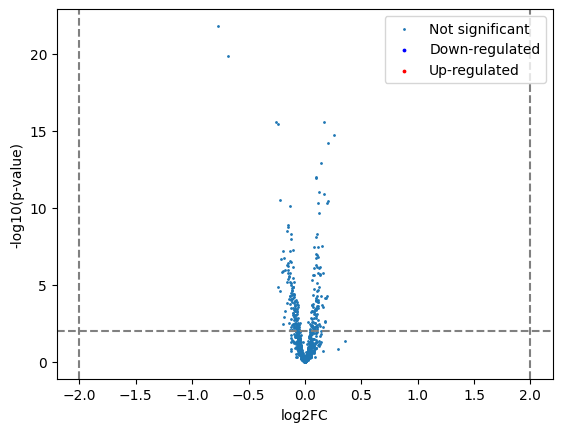

In [7]:
plt.scatter(x=df_cn_mci['log2FC'],y=df_cn_mci['p-value'].apply(lambda x:-np.log10(x)),s=1,label="Not significant")

# highlight down- or up- regulated genes
down = df_cn_mci[(df_cn_mci['log2FC']<=-2)&(df_cn_mci['p-value']<=0.01)]
up = df_cn_mci[(df_cn_mci['log2FC']>=2)&(df_cn_mci['p-value']<=0.01)]

plt.scatter(x=down['log2FC'],y=down['p-value'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['log2FC'],y=up['p-value'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")
texts=[]
for i,r in up.iterrows():
    texts.append(plt.text(x=r['log2FC'],y=-np.log10(r['p-value']),s=i))
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
plt.xlabel("log2FC")
plt.ylabel("-log10(p-value)")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()

### CN vs AD

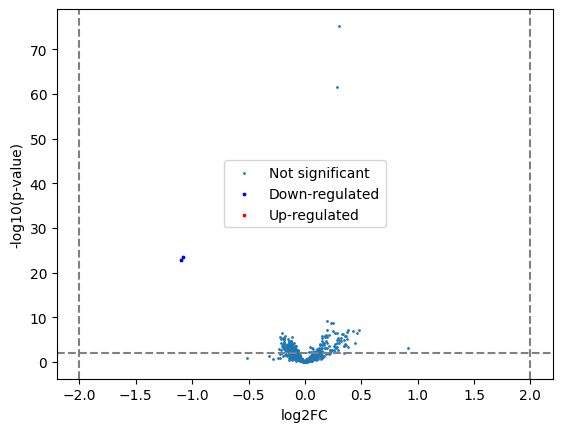

In [8]:
plt.scatter(x=df_cn_ad['log2FC'],y=df_cn_ad['p-value'].apply(lambda x:-np.log10(x)),s=1,label="Not significant")

# highlight down- or up- regulated genes
down = df_cn_ad[(df_cn_ad['log2FC']<=-1)&(df_cn_ad['p-value']<=0.01)]
up = df_cn_ad[(df_cn_ad['log2FC']>=1)&(df_cn_ad['p-value']<=0.01)]

plt.scatter(x=down['log2FC'],y=down['p-value'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['log2FC'],y=up['p-value'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")
texts=[]
for i,r in up.iterrows():
    texts.append(plt.text(x=r['log2FC'],y=-np.log10(r['p-value']),s=i))
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
plt.xlabel("log2FC")
plt.ylabel("-log10(p-value)")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()

### MCI vs AD

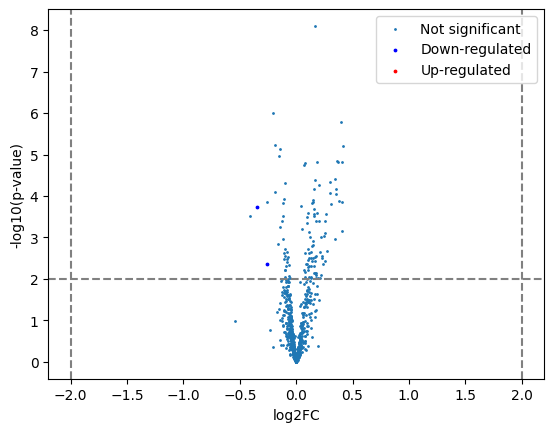

In [9]:
plt.scatter(x=df_mci_ad['log2FC'],y=df_mci_ad['p-value'].apply(lambda x:-np.log10(x)),s=1,label="Not significant")

# highlight down- or up- regulated genes
down = df_mci_ad[(df_cn_ad['log2FC']<=-1)&(df_mci_ad['p-value']<=0.01)]
up = df_mci_ad[(df_mci_ad['log2FC']>=1)&(df_mci_ad['p-value']<=0.01)]

plt.scatter(x=down['log2FC'],y=down['p-value'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['log2FC'],y=up['p-value'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")
texts=[]
for i,r in up.iterrows():
    texts.append(plt.text(x=r['log2FC'],y=-np.log10(r['p-value']),s=i))
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
plt.xlabel("log2FC")
plt.ylabel("-log10(p-value)")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()